In [1]:
# prompt: connect to drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install Pillow
from PIL import Image # Import Image from PIL
import cv2
import torch
import time
from datetime import datetime

In [ ]:
# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

In [ ]:
vehicle_classes = [2, 3, 5, 7]  # car, motorcycle, bus, truck

In [ ]:
# Camera sources (images instead of videos)
cam_sources = ['/content/sample_data/cam1.jpg',
               '/content/sample_data/cam2.jpg',
               '/content/sample_data/cam3.jpg',
               '/content/sample_data/cam4.jpg']
signal_names = ['North', 'East', 'South', 'West']

In [ ]:
# Vehicle type weights
vehicle_weights = {
    'car': 1,
    'motorcycle': 0.5,
    'bus': 2,
    'truck': 2.5
}


In [ ]:

def calculate_weighted_count(vehicles):
    count = 0
    for _, row in vehicles.iterrows():
        label = row['name']
        count += vehicle_weights.get(label, 1)
    return count


def calculate_green_signal(weighted_count):
    base_time = 5  # Minimum green time
    time_per_weight = 2
    return min(60, base_time + int(weighted_count * time_per_weight))


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-4-14 Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


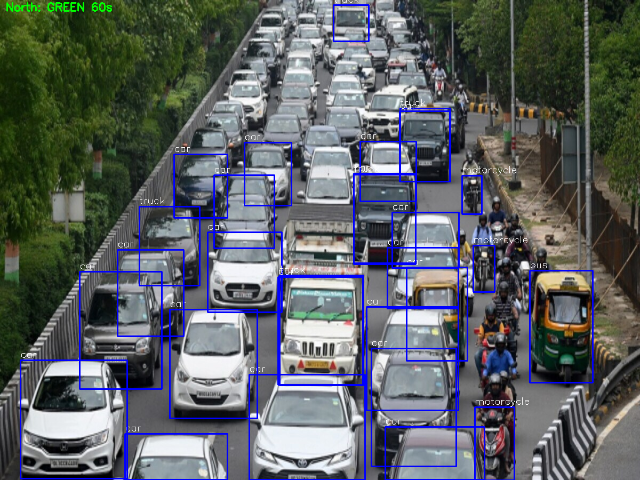

North GREEN for 60 seconds


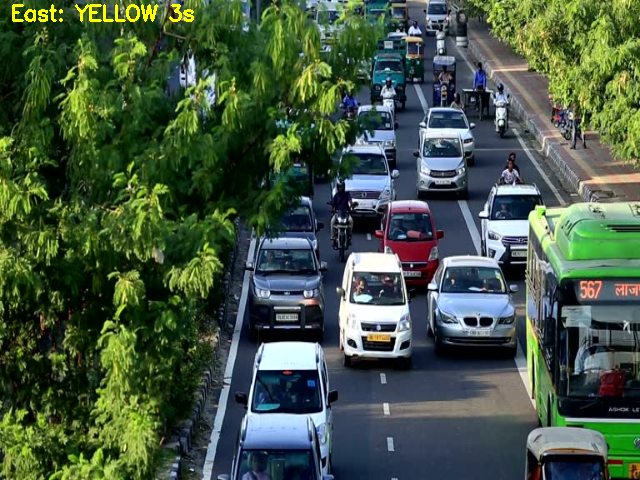

East YELLOW for 3 seconds


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


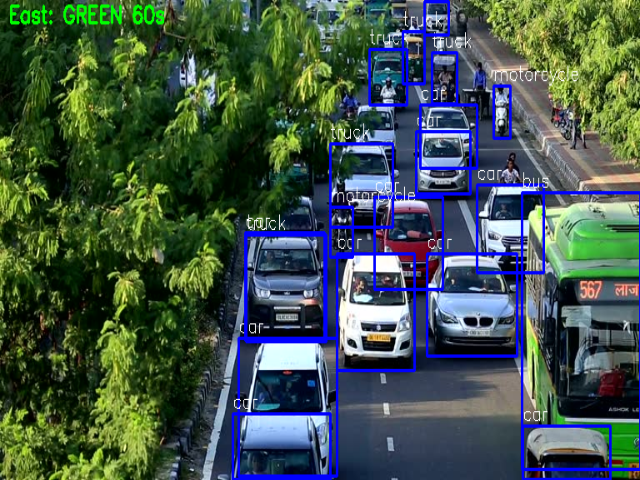

East GREEN for 60 seconds


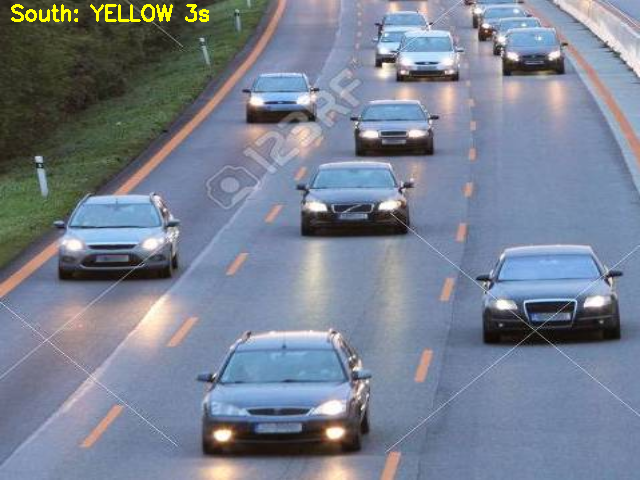

South YELLOW for 3 seconds


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


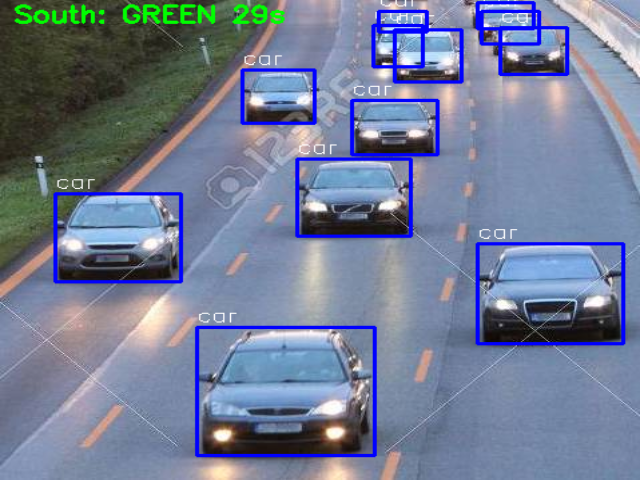

South GREEN for 29 seconds


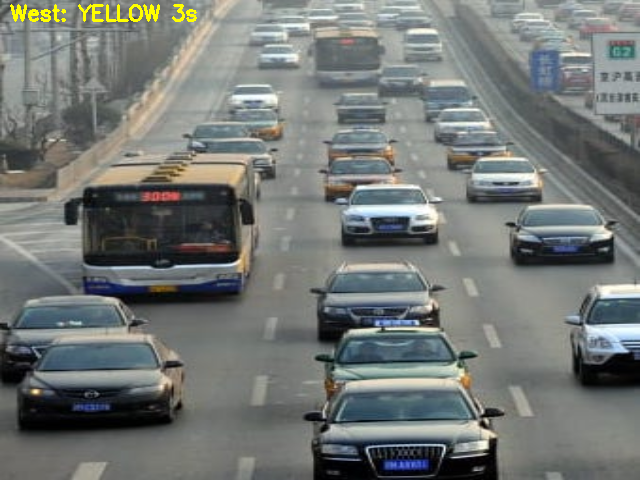

West YELLOW for 3 seconds


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


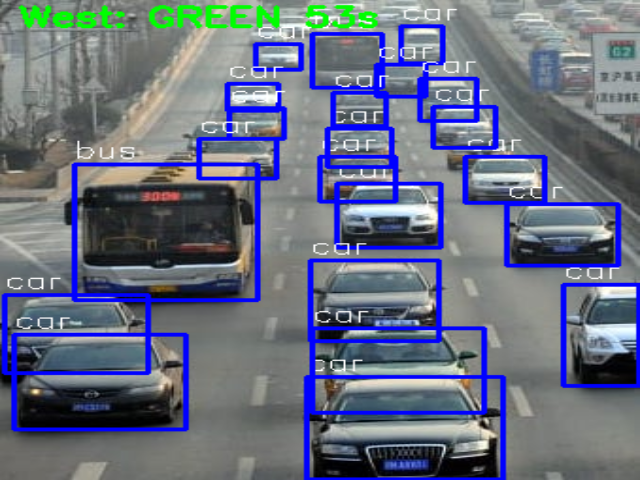

West GREEN for 53 seconds


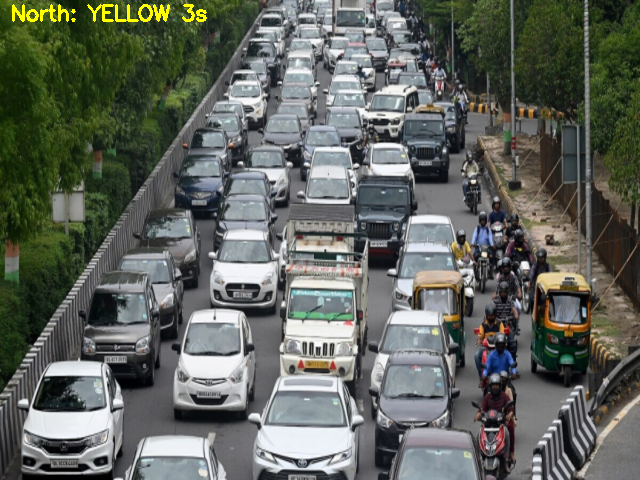

North YELLOW for 3 seconds


In [15]:


# Main logic for adaptive traffic signals
# If running in Google Colab, replace 'cv2.imshow' with 'display(Image.fromarray(resized_frame))' to show images
from IPython.display import display  # Keep this for displaying
import numpy as np

while True:
    for i in range(4):
        frame = cv2.imread(cam_sources[i])
        if frame is None:
            print(f"Image {cam_sources[i]} not found.")
            continue

        img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = model(img)
        df = results.pandas().xywh[0]
        vehicles = df[df['class'].isin(vehicle_classes)]

        vehicle_count = calculate_weighted_count(vehicles)
        green_duration = calculate_green_signal(vehicle_count)

        for _, row in vehicles.iterrows():
            x1 = int(row['xcenter'] - row['width'] / 2)
            y1 = int(row['ycenter'] - row['height'] / 2)
            x2 = int(row['xcenter'] + row['width'] / 2)
            y2 = int(row['ycenter'] + row['height'] / 2)
            label = row['name']
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(frame, label, (x1, y1 - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

        cv2.putText(frame, f'{signal_names[i]}: GREEN {green_duration}s', (10, 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

        resized_frame = cv2.resize(frame, (640, 480))
        # cv2.imshow(f"{signal_names[i]} Signal", resized_frame)
        # display the frame in Google Colab using IPython.display.Image
        # Convert BGR to RGB for display
        display(Image.fromarray(resized_frame[:, :, ::-1]))

        print(f"{signal_names[i]} GREEN for {green_duration} seconds")
        time.sleep(green_duration)  # use time.sleep instead of cv2.waitKey

        # Simulate 3 sec yellow signal for next signal
        next_index = (i + 1) % 4
        next_frame = cv2.imread(cam_sources[next_index])
        if next_frame is not None:
            next_frame = cv2.resize(next_frame, (640, 480))
            cv2.putText(next_frame, f'{signal_names[next_index]}: YELLOW 3s', (10, 20),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
            # cv2.imshow(f"{signal_names[next_index]} Signal", next_frame)
            # Convert BGR to RGB for display
            display(Image.fromarray(next_frame[:, :, ::-1]))
            print(f"{signal_names[next_index]} YELLOW for 3 seconds")
            time.sleep(3)  # use time.sleep instead of cv2.waitKey
            # cv2.destroyWindow(f"{signal_names[next_index]} Signal")

        # cv2.destroyWindow(f"{signal_names[i]} Signal")

    # Press 'q' to quit - Assuming 'q' pressing is not intended in this Colab environment
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #    break
    break  # Exit the loop after one cycle

# cv2.destroyAllWindows() # No need for this if cv2.imshow is not used